# A Numba Mandelbrot Example

This is an example that demonstrates accelerating a Mandelbrot fractal computation using "CUDA Python" with Numba.

Let's start with a basic Python Mandelbrot set. We use a numpy array for the image and display it using pylab imshow.

In [1]:
import numpy as np
from pylab import imshow, show
from timeit import default_timer as timer

The `mandel` function performs the Mandelbrot set calculation for a given (x,y) position on the imaginary plane. It returns the number of iterations before the computation "escapes".

In [2]:
def mandel(x, y, max_iters):
  """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters

`create_fractal` iterates over all the pixels in the image, computing the complex coordinates from the pixel coordinates, and calls the `mandel` function at each pixel. The return value of `mandel` is used to color the pixel.

In [3]:
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height
    
  for x in range(width):
    real = min_x + x * pixel_size_x
    for y in range(height):
      imag = min_y + y * pixel_size_y
      color = mandel(real, imag, iters)
      image[y, x] = color

Next we create a 1536x1024 pixel image as a numpy array of bytes. We then call `create_fractal` with appropriate coordinates to fit the whole mandelbrot set.

Mandelbrot created in 4.967389 s


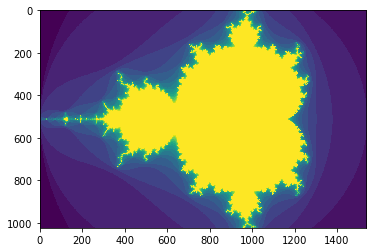

In [5]:
image = np.zeros((1024, 1536), dtype = np.uint8)
start = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20) 
dt = timer() - start

print "Mandelbrot created in %f s" % dt
imshow(image)
show()

You can play with the coordinates to zoom in on different regions in the fractal.

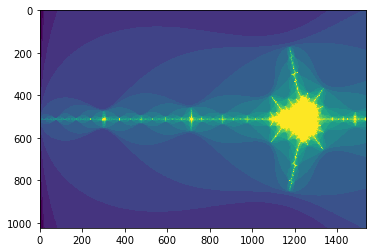

In [6]:
create_fractal(-2.0, -1.7, -0.1, 0.1, image, 20) 
imshow(image)
show()

## Faster Execution with Numba

[Numba](https://github.com/numba/numba) is a Numpy-aware dynamic Python compiler based on the popular LLVM compiler infrastructure. 

Numba is an Open Source NumPy-aware optimizing compiler for Python sponsored by Anaconda. It uses the LLVM compiler infrastructure to compile Python syntax to machine code. It is aware of NumPy arrays as typed memory regions and so can speed-up code using NumPy arrays, such as our Mandelbrot functions.

The simplest way to use Numba is to decorate the functions you want to compile with @autojit. Numba will compile them for the CPU (if it can resolve the types used).

In [7]:
from numba import autojit

@autojit
def mandel(x, y, max_iters):
  """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters

@autojit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height
    
  for x in range(width):
    real = min_x + x * pixel_size_x
    for y in range(height):
      imag = min_y + y * pixel_size_y
      color = mandel(real, imag, iters)
      image[y, x] = color

Let's run the `@autojit` code and see if it is faster.

Mandelbrot created in 0.667907 s


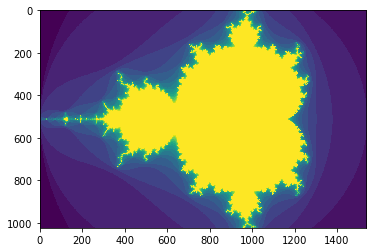

In [8]:
image = np.zeros((1024, 1536), dtype = np.uint8)
start = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20) 
dt = timer() - start

print "Mandelbrot created in %f s" % dt
imshow(image)
show()

On a server with a Xeon (Haswell) CPU, the time to compute the 1536x1024 mandelbrot set dropped from 4.94s down to 46.6ms. That's a speedup of 106x! The reason this is so much faster is that Numba uses Numpy type information to convert the dynamic Python code into statically compiled machine code, which is many times faster to execute than dynamically typed, interpreted Python code. 

## Even Bigger Speedups with CUDA Python

In addition to various types of automatic vectorization and generalized Numpy Ufuncs, Numba also enables developers to access the CUDA parallel programming model using Python syntax. With CUDA Python, you use parallelism explicitly, just as in other CUDA languages such as CUDA C++ and CUDA Fortran. 

Let's write a CUDA version of our Python Mandelbrot set. We need to import `cuda` from the `numba` module. Then, we need to create a version of the mandel function compiled for the GPU. We can do this without any code duplication by calling `cuda.jit` on the function, specifying `device=True` to indicate that this is a function that will run on the GPU *device*.

In [9]:
from numba import cuda
from numba import *

mandel_gpu = cuda.jit(device=True)(mandel)

In CUDA, a *kernel* is a function that runs in parallel using many threads on the device. We can write a kernel version of our mandelbrot function by simply assuming that it will be run by a *grid* of threads. NumbaPro provides the familiar CUDA `threadIdx`, `blockIdx`, `blockDim` and `gridDim` intrinsics, as well as a `grid()` convenience function which evaluates to `blockDim * blockIdx + threadIdx`.

Our example juse needs a minor modification to compute a grid-size stride for the x and y ranges, since we will have many threads running in parallel. We just add these three lines:

    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x;
    gridY = cuda.gridDim.y * cuda.blockDim.y;

And we modify the range in the `x` loop to use `range(startX, width, gridX)` (and likewise for the `y` loop).

We decorate the function with @cuda.jit. Numba will infer the type signature from the invocation of the function.

In [10]:
@cuda.jit
def mandel_kernel(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height

  startX, startY = cuda.grid(2)
  gridX = cuda.gridDim.x * cuda.blockDim.x;
  gridY = cuda.gridDim.y * cuda.blockDim.y;

  for x in range(startX, width, gridX):
    real = min_x + x * pixel_size_x
    for y in range(startY, height, gridY):
      imag = min_y + y * pixel_size_y 
      image[y, x] = mandel_gpu(real, imag, iters)

#### Device Memory

CUDA kernels must operate on data allocated on the device. NumbaPro provides the cuda.to_device() function to copy a Numpy array to the GPU. 

    d_image = cuda.to_device(image)

The return value (`d_image`) is of type DeviceNDArray, which is a subclass of numpy.ndarray, and provides the `to_host()` function to copy the array back from GPU to CPU memory

    d_image.to_host()

#### Launching Kernels

To launch a kernel on the GPU, we must configure it, specifying the size of the grid in blocks, and the size of each thread block. For a 2D image calculation like the Mandelbrot set, we use a 2D grid of 2D blocks. We'll use blocks of 32x8 threads, and launch 32x16 of them in a 2D grid so that we have plenty of blocks to occupy all of the multiprocessors on the GPU.

Putting this all together, we launch the kernel like this.

Mandelbrot created on GPU in 0.002815 s


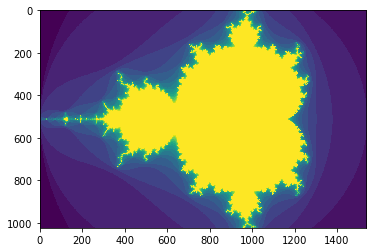

In [13]:
gimage = np.zeros((1024, 1536), dtype = np.uint8)
blockdim = (32, 8)
griddim = (32,16)

start = timer()
d_image = cuda.to_device(gimage)
mandel_kernel[griddim, blockdim](-2.0, 1.0, -1.0, 1.0, d_image, 20) 
d_image.to_host()
dt = timer() - start

print "Mandelbrot created on GPU in %f s" % dt

imshow(gimage)
show()

You may need to run this last code block twice to see the best performance, because of the JIT and kernel loading overhead the first time you run it. The second time you run it, you may notice that the image was generated almost instantly. On the NVIDIA Tesla P100 GPU installed in my server, it ran in 2.9 milliseconds, which is an additional 16x speedup over the `@autojit` (compiled CPU) code, or a total of nearly 1700x faster than interpreted Python code.

Productivity *and* Performance!

Numba is free and open source software.